# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install -U kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "danielpmathews"
kaggle_key = "6b4d5550ca29d4bf26a121eacdeeb293"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [ ]:
train = pd.read_csv('train.csv',parse_dates=['datetime'])
test = pd.read_csv('test.csv',parse_dates=['datetime'])
submission = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])

In [ ]:
train.head(1)

In [ ]:
train.dtypes

In [ ]:
test.head(1)

In [ ]:
submission.head(1)

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor = TabularPredictor.load('AutogluonModels/ag-20240625_234407')

In [16]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.133772  root_mean_squared_error      20.601956  390.345274                0.000753           0.053419            3       True         12
1   RandomForestMSE_BAG_L2  -53.470050  root_mean_squared_error      16.719526  296.650828                0.882535          44.197278            2       True         11
2          LightGBM_BAG_L2  -54.968202  root_mean_squared_error      16.169971  283.531779                0.332980          31.078229            2       True         10
3        LightGBMXT_BAG_L2  -60.551453  root_mean_squared_error      19.385688  315.016348                3.548697          62.562798            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.071029    0.038803   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.96837629032783,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble

### Create predictions from test dataset

In [22]:
predictor.model_names()

['KNeighborsUnif_BAG_L1',
 'KNeighborsDist_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBM_BAG_L1',
 'RandomForestMSE_BAG_L1',
 'CatBoost_BAG_L1',
 'ExtraTreesMSE_BAG_L1',
 'WeightedEnsemble_L2',
 'LightGBMXT_BAG_L2',
 'LightGBM_BAG_L2',
 'RandomForestMSE_BAG_L2',
 'WeightedEnsemble_L3']

In [23]:
predictions = predictor.predict(test, model='WeightedEnsemble_L3')
predictions.head()

0    24.021990
1    43.417591
2    46.283195
3    49.363735
4    52.423946
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [24]:
(predictions<0).sum()

0

In [25]:
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [26]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 733kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv               2024-07-23 00:13:19  first raw submission  complete  1.80255      1.80255       
submission.csv               2024-07-23 00:08:47  first raw submission  complete  1.80255      1.80255       
submission_new_features.csv  2024-05-06 23:00:59  new features          complete  1.80175      1.80175       
submission.csv               2024-05-06 22:05:29  first raw submission  complete  1.80175      1.80175       


#### Initial score of 1.80175

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

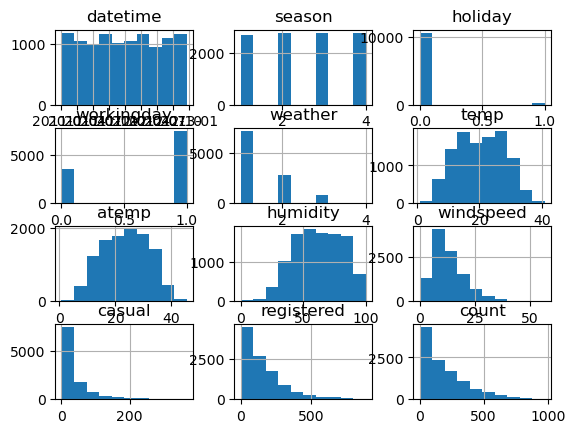

In [29]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [30]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month
train['day'] = train['datetime'].dt.day
test['day'] = test['datetime'].dt.day

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [31]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')

train["season"] = train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train["weather"] = train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [32]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,day
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,4,1,1


In [35]:
train.dtypes

datetime      datetime64[ns]
season              category
holiday                int64
workingday             int64
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
hour                   int32
month                  int32
day                    int32
dtype: object

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'day'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

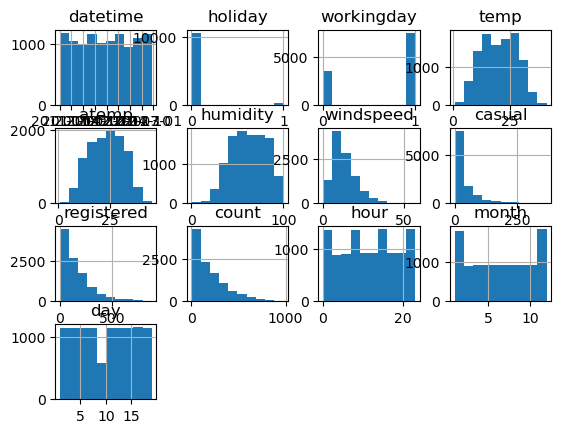

In [36]:
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [37]:
predictor_new_features = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240723_002115"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
CPU Count:          2
Memory Avail:       2.23 GB / 3.76 GB (59.2%)
Disk Space Avail:   8589934587.01 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

(_ray_fit pid=651) [1000]	valid_set's rmse: 39.047
(_ray_fit pid=651) [5000]	valid_set's rmse: 36.143 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=712) [1000]	valid_set's rmse: 39.8039 [repeated 7x across cluster]
(_ray_fit pid=712) [4000]	valid_set's rmse: 37.3204 [repeated 6x across cluster]
(_ray_fit pid=737) [7000]	valid_set's rmse: 35.1048 [repeated 7x across cluster]
(_ray_fit pid=767) [1000]	valid_set's rmse: 35.2602
(_ray_fit pid=792) [1000]	valid_set's rmse: 37.6615
(_ray_fit pid=767) [5000]	valid_set's rmse: 33.5052 [repeated 7x across cluster]
(_ray_fit pid=767) [9000]	valid_set's rmse: 33.3894 [repeated 4x across cluster]
(_ray_fit pid=823) [3000]	valid_set's rmse: 34.5121 [repeated 3x across cluster]
(_ray_fit pid=856) [1000]	valid_set's rmse: 37.1911 [repeated 3x across cluster]


(_dystack pid=532) 	-35.0836	 = Validation score   (-root_mean_squared_error)
(_dystack pid=532) 	79.3s	 = Training   runtime
(_dystack pid=532) 	8.96s	 = Validation runtime
(_dystack pid=532) Fitting model: LightGBM_BAG_L1 ... Training model for up to 7.69s of the 55.75s of remaining time.
(_dystack pid=532) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.49%)
(_dystack pid=532) 	-34.7083	 = Validation score   (-root_mean_squared_error)
(_dystack pid=532) 	22.88s	 = Training   runtime
(_dystack pid=532) 	0.86s	 = Validation runtime
(_dystack pid=532) Fitting model: WeightedEnsemble_L2 ... Training model for up to 144.13s of the 27.93s of remaining time.
(_dystack pid=532) 	Ensemble Weights: {'LightGBM_BAG_L1': 0.529, 'LightGBMXT_BAG_L1': 0.471}
(_dystack pid=532) 	-33.3402	 = Validation score   (-root_mean_squared_error)
(_dystack pid=532) 	0.02s	 = Training   runtime
(_dystack pid=532) 	0.0s	 = Validation

In [38]:
predictor_new_features.fit_summary()

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.281212  root_mean_squared_error      16.981292  344.747175                0.000721           0.040091            3       True         13
1          LightGBM_BAG_L2  -30.547149  root_mean_squared_error      15.083699  278.995859                0.367743          25.196407            2       True         10
2        LightGBMXT_BAG_L2  -31.111185  root_mean_squared_error      16.527938  288.263829                1.811981          34.464377            2       True          9
3          CatBoost_BAG_L2  -31.297172  root_mean_squared_error      14.800847  285.046301                0.084891          31.246848            2       True         12
4   RandomForestMSE_BAG_L2  -31.779110  root_mean_squared_error      15.331273  289.490481   

0    13.603956
1     9.209279
2     8.420923
3     7.365537
4     6.321885
Name: count, dtype: float32

In [39]:
predictions = predictor_new_features.predict(test)
predictions.head()

0    13.603956
1     9.209279
2     8.420923
3     7.365537
4     6.321885
Name: count, dtype: float32

In [40]:
print((predictions<0).sum())
predictions[predictions<0] = 0

0


In [41]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [42]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 771kB/s]
Successfully submitted to Bike Sharing Demand

In [43]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-07-23 00:33:38  new features          complete  0.65116      0.65116       
submission.csv               2024-07-23 00:13:19  first raw submission  complete  1.80255      1.80255       
submission.csv               2024-07-23 00:08:47  first raw submission  complete  1.80255      1.80255       
submission_new_features.csv  2024-05-06 23:00:59  new features          complete  1.80175      1.80175       


#### New Score of 0.65116

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [44]:
hyperparameters = {
    'GBM': {'num_boost_round': 100, 'learning_rate': 0.1, 'num_leaves': 31},
    'XT': {'n_estimators': 100, 'max_depth': None},
    'XGB': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6},
    'RF': {'n_estimators': 100, 'max_depth': None},
    'KNN': {'n_neighbors': 5, 'weights': 'uniform'}
}

In [45]:
predictor_new_hpo = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(
    train,
    presets='best_quality',
    time_limit=600,
    hyperparameters=hyperparameters)

No path specified. Models will be saved in: "AutogluonModels/ag-20240723_004750"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
CPU Count:          2
Memory Avail:       1.60 GB / 3.76 GB (42.7%)
Disk Space Avail:   8589934586.58 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [46]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -33.369648  root_mean_squared_error       1.639034  82.014141                0.000811           0.041636            3       True         11
1       LightGBM_BAG_L2  -33.527911  root_mean_squared_error       0.987290  54.684027                0.133319          17.911023            2       True          7
2        XGBoost_BAG_L2  -34.052901  root_mean_squared_error       1.081250  50.619161                0.227279          13.846157            2       True         10
3     ExtraTrees_BAG_L2  -34.754475  root_mean_squared_error       1.060878  39.781672                0.206907           3.008668            2       True          9
4   RandomForest_BAG_L2  -34.904878  root_mean_squared_error       1.070718  47.206657                0.216747   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighbors_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighbors_BAG_L1': -101.54619908446061,
  'LightGBM_BAG_L1': -37.21698626585365,
  'RandomForest_BAG_L1': -38.944827055113336,
  'ExtraTrees_BAG_L1': -39.38788671340839,
  'XGBoost_BAG_L1': -38.0296931058879,
  'WeightedEnsemble_L2': -35.554481500698714,
  'LightGBM_BAG_L2': -33.52791142545627,
  'RandomForest_BAG_L2': -34.90487813686588,
  'ExtraTrees_BAG_L2': -34.754474818100675,
  'XGBoost_BAG_L2

In [47]:
# set to 0
print((predictions<0).sum())
predictions[predictions<0] = 0

0


In [48]:
predictions = predictor_new_hpo.predict(test)
predictions.head()

0    14.741365
1    10.126247
2     9.070167
3     8.191153
4     7.305253
Name: count, dtype: float32

In [49]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_new_hpo["count"] = predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [50]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 776kB/s]
Successfully submitted to Bike Sharing Demand

In [51]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-07-23 00:51:21  new features with hyperparameters  complete  0.55005      0.55005       
submission_new_features.csv  2024-07-23 00:33:38  new features                       complete  0.65116      0.65116       
submission.csv               2024-07-23 00:13:19  first raw submission               complete  1.80255      1.80255       
submission.csv               2024-07-23 00:08:47  first raw submission               complete  1.80255      1.80255       


#### New Score of 0.55005

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

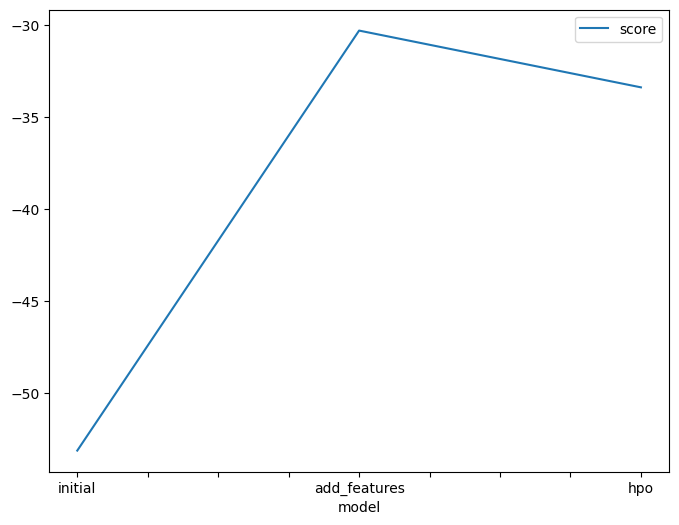

In [54]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.133772,-30.281212,-33.369648]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

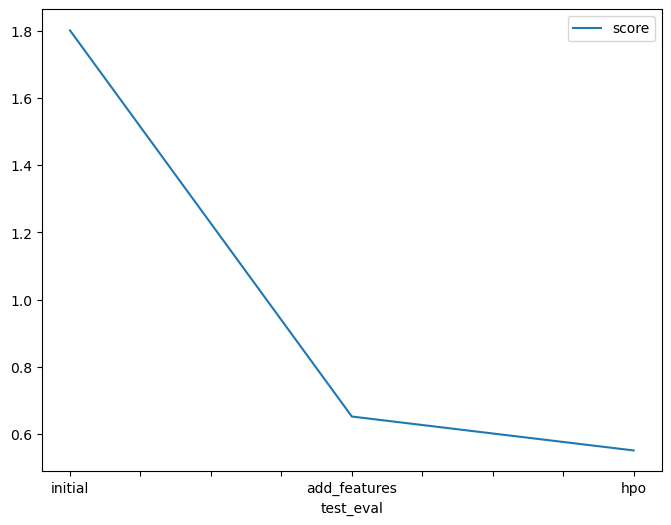

In [53]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80255, 0.65116, 0.55005]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['prescribed_values', 'prescribed_values', "Tree-Based Models: (GBM, XT, XGB, & RF)"],
    "hpo2": ['prescribed_values', 'prescribed_values', "KNN"],
    "hpo3": [?, ?, "presets: 'best_quality"],
    "score": [1.80255, 0.65116, 0.55005]
})